![banner](./images/banner.png "banner")

[Fuente de la imagen](https://unsplash.com/photos/Hcfwew744z4)
<a name='toc' />

# <font color=#ac6240>Cuantificación de la incertidumbre en la predicción de fallo cardíaco con aprendizaje automático supervisado</font>

### <font color=#ac6240>Tabla de Contenidos</font>

<a href=#pre>Requisitos previos</a><br>
1. <a href=#project-description>Descripción del proyecto</a><br>
    1.1 <a href=#project-description-intro>Introducción</a><br>
    1.2 <a href=#project-description-goal>Objetivo</a><br>
    1.3 <a href=#project-description-data>Datos y modelo de aprendizaje automático</a><br>
    1.4 <a href=#project-description-calibracion>Calibración</a><br>
    1.5 <a href=#project-description-software>Software</a><br>
2. <a href=#prep>Preparación de los datos</a><br>
    2.1 <a href=#prep-clean> Limpieza de los datos</a><br>
    2.2 <a href=#prep-split> Division de los datos en conjuntos de datos de entrenamiento, validación y prueba</a><br>
    2.3 <a href=#prep-encoding> Codificación y normalización de las 'features'</a><br>
3. <a href=#model-ml>Aplicación del modelo de aprendizaje automático: Bosque Aleatorio</a><br>
    3.1 <a href=#model-metric> Selección de la métrica y del umbral de decisión </a><br>
    3.2 <a href=#model-RF> Entrenamiento, prueba, y evaluación del bosque aleatorio </a><br>
4. <a href=#app-uq>Cuantificación de incertidumbre</a><br>
    4.1 <a href=#uq-cp> Conformal Predictors </a><br>
    4.2 <a href=#uq-ivap> Intervalos de predicción de fallo cardíaco con Inductive Venn-ABERS Prediction </a><br>
    4.3 <a href=#uq-others> Otros métodos de UQ para aprendizaje supervisado </a><br>
    4.4 <a href=#miscelanea> Miscelánea </a><br>
    
5. <a href=#uq-end>Conclusión sobre la cuantificación de incertidumbre</a><br>

Antes de nada, me gustaría agradecer a les expertes [Maria Navarro](https://www.linkedin.com/in/maria-navarro-jimenez/) y a [Valeriy Manokhin](https://www.linkedin.com/in/valeriy-manokhin-phd-mba-cqf-704731236/) su inestimable ayuda en la elaboracion de este Jupyer Notebook. Podéis encontrar las referencias a sus trabajos acreditadas a lo largo de este taller.

<font size="5">😊 </font>

<a name='pre'/>

## <font color=#ac6240>Requisitos previos</font>

Este Jupyter Notebook puede recorrerse de manera independiente aunque es la continuación de los Jupyter Notebooks de [este repositorio](https://github.com/MMdeCastro/Uncertainty_Quantification_XAI):
+ `Exploration_and_Classification.ipynb` donde explicamos cómo explorar exhaustivamente los datos de pacientes que sufrieron o no fallo cardíaco y cómo evaluar la calidad de un modelo de aprendizaje automático supervisado con métricas de rendimiento; elegimos el modelo que mejor se comportaba para este proyecto de predicción de fallo cardíaco y era un bosque aleatorio, y
+ `XAI.ipynb` donde aplicamos varios métodos de explicabilidad sobre las predicciones de ese bosque aleatorio para entender en qué se fijó el modelo para clasificar a les pacientes.

En el README.md del repositorio del taller están los enlaces a varias charlas sobre UQ, en particular aconsejamos mirar éstas dos presentaciones (contienen animaciones): 

+ [Intro to UQ with Conformal Prediction](https://docs.google.com/presentation/d/1Q6oxcgmNv0GsmNFA5npAzQGDuy_XolBKStN4KUhP4Gk/edit#slide=id.g2c6fde0c8c9_0_0) with a multiclass example (in English).
+ [Key Concepts of Conformal Prediction](https://docs.google.com/presentation/d/1bQYIFyQysQPx79wJq1mltylsH_aeO2AnLYRlHiLq6vo/edit#slide=id.g2dc32e8043a_0_5) (in English).


<font size="5"> 👍🤓</font>

<a name='project-description'/>

##  <font color=#ac6240>1. Descripción del proyecto</font>

<a name='project-description-intro'/>

### <font color=#ac6240>1.1 Introducción</font>

Estamos acostumbrades a modelos de aprendizaje automático que nos devuelven una predicción en forma de un único valor puntual ('single-value prediction'). Estos modelos no tienen ninguna manera de manifestar si están muy seguros o no de lo que predicen, por ejemplo, proporcionando una distribución o rango de resultados razonables, para que podamos representar la predicción con unas 'barras de error' en lugar de con un solo punto. 

La falta de información sobre la certeza que tiene un modelo sobre los resultados que arroja es especialmente problemático cuando:
+ el modelo no es interpretable, es una 'black box' o caja opaca, (explicamos estos conceptos en el Jupyter Notebook anterior `XAI.ipynb`), o
+ pedimos al modelo que prediga un resultado sobre una instancia anómala ('outlier') que no se parece a los datos históricos con los que ese modelo fue entrenado, algo relacionado con el fenómeno denominado ['drift'](https://en.wikipedia.org/wiki/Drift_(data_science)) (más info sobre la definición de 'deriva' o desplazamiento 'shift' y sus diferentes tipos, [aquí](https://analyticsindiamag.com/concept-drift-vs-data-drift-in-machine-learning/)), lo cual es indeseado y puede pasar fácilmente desapercibido. 

Por último remarcar que medir la certeza de las predicciones es especialmente útil en aplicaciones sensibles o de riesgo donde desarrollar algoritmos robustos y confiables es esencial. Según el acta reguladora de la inteligencia artificial de la Unión Europea, [The AI Act](https://artificialintelligenceact.eu/the-act/):

    "The purpose of this Regulation is to improve the functioning of the internal market and promoting the uptake of human centric and trustworthy artificial intelligence".

Como ejemplo sencillo, supongamos que entrenamos una red neuronal artificial (que no es interpretable) con imágenes de perres y gates con la tarea de distinguir entre perres y gates. Digamos que el umbral de decisión es tal que las instancias, es decir, las fotos, cuya 'raw score' sea mayor de 0.5 serán clasificadas como gates y el resto como perres, como en una típica clasificación binaria. Supongamos además que conseguimos que la red neuronal artificial tenga un rendimiento excelente sobre los datos de validación y testado, puede que incluso tenga un 99.5% en 'accuracy' sobre ambos conjuntos. Ahora, aplicamos la red y le pedimos que clasifique estas fotos:

![cat_dog_bird](./images/cat_dog_bird.png "cat_dog_bird")

[Fuente de la imagen: _"Are you sure about that?! Uncertainty Quantification in AI"_](https://florianwilhelm.info/2019/10/uncertainty_quantification_in_ai/)

Y vemos que ocurre lo siguiente:
+ para la foto de la izquierda nos da una 'raw score' de 0.9, así que predice correctamente que es la imagen de une gate,
+ para la foto del centro obtenemos una 'raw score' de 0.5, y a la vista de la imagen _interpretamos_ que a la red le costó darnos una clasificación correcta (nos la dió por los pelos) y que _obviamente_ no está _tan segura_ porque le perre de la imagen parece un poco une gate, pero...

¿y si le pedimos que clasifique la figura de la derecha? Cualquier cosa puede pasar, nos puede dar una 'raw score' por encima o por debajo de 0.5 o exactamente 0.5, pero en cualquier caso, sabemos que no es fiable. Y la cuestión es que **el modelo de aprendizaje automático no nos podría decir 'hey, no tengo ni idea' porque las 'raw scores' no muestran certidumbre**, a pesar de lo que todes hemos erróneamente interpretado alguna vez.  

![tweet_uq](./images/tweet_uq.png "tweet_uq")

En una tarea de regresión ocurre lo mismo. Entrenamos el modelo con un gran conjunto de datos de precios de casas y al aplicarlo sobre una casa nos da cómo resultado, por ejemplo, 135.896,73 euros. La probabilidad de que el precio verdadero de la casa sea ese es nula. Si el modelo rinde bien, el precio verdadero estará cerca de ese valor, estará dentro de un intervalo de predicción alrededor de ese valor. Cuanto más ancho el intervalo, más grande la incertidumbre.

Y es importante recordar que los modelos de aprendizaje automático supervisado están diseñados para interpolar, **no para extrapolar, ni para identificar relaciones de causa-efecto, ni para abstraer conocimiento,... por lo cual les cuesta generalizar y pueden caer en el atajo de basar sus predicciones en correlaciones espúreas y sin sentido**. Si no damos al modelo la oportunidad de avisarnos de que no está preparado para desempeñar la tarea, nos dará igualmente una predicción, y tomaremos que está igual de seguro de esa predicción como lo está de la predicción de una instancia estándar para la que sí está entrenado. Sería mucho más adecuado que el modelo de aprendizaje automático nos informara de la certeza de sus resultados.  

Saber qué no sabemos, i.e, cuantificar la incertidumbre, mejora la calidad de las decisiones para poder descartar las predicciones con alta incertidumbre y derivar las decisiones a expertes humanos, como ocurre en el denominado ['Active Learning'](https://en.wikipedia.org/wiki/Active_learning_(machine_learning)). Como ejemplo, el vídeo del artículo [Robots That Ask For Help](https://robot-help.github.io/) de les desarrolladores del Large Language Model de Google, donde cuantifican incertidumbre con Predicción Conforme, el método que explicamos en la sección <a href=#app-uq>4. Aplicación de métodos de cuantificacion de incertidumbre</a><br>.

<font color=#6B8E23 size="3">Ejemplos mostrando que las métricas de rendimiento como "accurary" no son suficientes y no indican certeza</font>

+ [Métrica incorrecta](https://koaning.io/posts/goodheart-bad-metric/), sobre la [ley de Goodhart](https://es.wikipedia.org/wiki/Ley_de_Goodhart): "cuando la métrica se convierte el objetivo a optimizar, pierde su valor"
+ [La optimización métrica no es suficiente](https://koaning.io/posts/high-on-probability-low-on-certainty/),
+ [Mean Squared Terror](https://koaning.io/posts/mean-squared-terror/),
+ [Accuracy as a Failure](https://www.infoq.com/presentations/project-failure-data-accuracy/),
+ [How to calibrate your classifier in an intelligent way using Machine Learning Conformal Prediction](https://valeman.medium.com/how-to-calibrate-your-classifier-in-an-intelligent-way-a996a2faf718),
+ [Correlaciones espúreas divertidas](http://www.tylervigen.com/spurious-correlations).

#### <font color=#ac6240>1.1.1 Definición de Incertidumbre</font>

Según la Wikipedia en castellano (consultada el 26.09.2022):

![uncertainty_wp](./images/uncertainty_wp.png "uncertainty_wp")

[Fuente de la imagen](https://es.wikipedia.org/wiki/Incertidumbre)

Vamos, que el asunto va de lo que pasa cuando queremos medir u observar algo o predecir cuánto valdrá algo. 

Consultemos ahora a les expertes en [metrología](https://es.wikipedia.org/wiki/Metrolog%C3%ADa), es decir, la Oficina Internacional de Pesas y Medidas ([BIPM](https://www.bipm.org/en/committees/jc/jcgm/), por sus siglas en francés) cuyo Joint Committee for Guides in Metrology (JCGM) publica la Guía para la expresión de la Incertidumbre en la Medida (GUM, por sus siglas en inglés) que incluye el International Vocabulary of basic and general terms in Metrology ([VIM](https://www.bipm.org/en/committees/jc/jcgm/publications) JCGM_100_2008_E-1)

<font size="5">🤪🤯</font>


donde se define:

<blockquote>

**2.2 The term 'uncertainty'**

[...] Uncertainty (of measurement) [is a] parameter, associated with the result of a measurement, that characterizes the dispersion of the values that could reasonably be attributed to the measurand. [...] The parameter may be, for example, a standard deviation (or a given multiple of it), or the half-width of an interval having a stated level of confidence.
</blockquote>

y también:

<blockquote>
    
**3.3. Uncertainty**

The uncertainty of the result of a measurement reflects the lack of exact knowledge of the value of the measurand.
</blockquote>

Antes de ver qué significa esto en el contexto del aprendizaje automático, hagamos una aclaración importante para distinguir bien entre los conceptos de incentidumbre, error, residuo y sesgo o 'bias'.

#### <font color=#ac6240>1.1.2 Incertidumbre vs error vs residuo vs bias</font>

El **error** es la diferencia entre el valor verdadero, (asumiento que existe y se puede definir, ojo, que aquí esto es clave), y el valor resultado de la medición o predicción, por ejemplo, realizada empíricamente con un aparato de medida o en nuestro caso, el dato de si le paciente sufre o no fallo cardíaco. 

Si ese valor verdadero lo defimos por un modelo, esa diferencia entre la medición y el modelo también se llama **residuo**, por ejemplo, la distancia entre un punto `(x,y)` (el dato resultado de la medición) y la recta de regresión lineal que intenta representar, es decir, modelar la realidad, que representan esos los datos, `y = mx + n`, y que idealizamos como representación de la realidad. Vimos la regresión lineal brevemente en la seccion 4.1 Modelo de referencia inicial para la selección de la métrica: Regresión Logística del Jupyter Notebook `Exploration_and_Classification.ipynb`.

Entonces, en la representacion tradicional, la desviación entre el valor obtenido de la medición y el ansiado supuesto valor verdadero se compone de dos tipos de errores:
+ el error aleatorio, la componente debida a la naturaleza [estocástica](https://en.wikipedia.org/wiki/Stochastic_process#Examples) del sistema, y
+ el error sistemático, también llamado **sesgo o 'bias'**, que es la componente reducible porque su media no es cero y se puede compensar con un 'factor de correccion' (mencionamos los problemas éticos del sesgo en IA en la intro del Jupyter Notebook `XAI.ipynb`).

En la Introducción del nuevo informe de 2012 [VIM 200:2012](https://www.bipm.org/en/committees/jc/jcgm/publications) se indica que estos dos tipos de errores no siempre son fáciles de diferenciar y que no disponemos de una regla general para ver cómo se combinan. Y también dice que normalmente estimamos el límite superior del valor absoluto del error total y que llamamos vagamente a eso 'incertidumbre'.

Pero la VIM también nos indica que es mejor no seguir ese punto de vista tradicional del 'error' porque:

+ necesita de la asumpción de la existencia un 'valor verdadero', y 
+ su objetivo es minimizar cualquier diferencia entre el resultado de la medida y ese supuesto 'valor verdadero', porque considera el error como una imperfección indeseable,

siendo más adecuado tratar la dispersión de los resultados de las mediciones como una 'incertidumbre' que:

+ aporta valiosa información y detalles significativos del comportamiento del sistema, y 
+ nos permite asumir que **la medición solo se puede expresar como un intervalo de valores razonables**.

<font size="5"> 👏 </font> 

Veamos ahora a qué nos referimos con "intervalo de valores razonable".

#### <font color=#ac6240>1.1.3 Intervalo de valores razonables</font>

Hay muchas maneras de definir qué entendemos por un 'intervalo de valores razonables' que nos permita cuantificar la posible variabilidad de los resultados y por tanto, la incertidumbre de la medición.

Los métodos de UQ que aquí explicamos nos proveen de un [intervalo de predicción](https://en.wikipedia.org/wiki/Prediction_interval) para cada predicción, es decir, es una estimación del rango de valores que con la probabilidad que determinamos con el llamado 'nivel de confianza' (por ejemplo, con 0.90 tendremos el 90% de probabilidad) incluirá el valor correcto. 

Cuanto más estrecho es el intervalo de predicción, más podemos confiar en la predicción. Por ejemplo, data una predicción, `y_pred = 100`, calculamos su intervalo de predicción para que contenga al valor verdadero con un 90% de probabilidad, es decir, de cada 100 intervalos que construyeramos, 90 contendrían a las "ground truth". Y la anchura del intervalo nos indica la confianza: si obtenemos el intervalo [99, 101] confiamos en el resultado más que si obtenemos el intervalo [50, 120].

###### Diferencias entre intervalos
[Intervalos de predicción](https://en.wikipedia.org/wiki/Prediction_interval): los que calculamos con Predicción Conforme, el método que explicamos en la sección <a href=#app-uq>4. Aplicación de métodos de cuantificacion de incertidumbre</a>, con garantía estadística contienen a la "ground truth", i.e., cumplen "validity", también llamada "garantía de cobertura". Si la tarea es de clasificación, contienen las clases en lugar de valores continuos y se llaman conjuntos de predicción e incluyen la "true label".

[Intervalos de confianza](https://es.wikipedia.org/wiki/Intervalo_de_confianza) de la estadística frecuentista: asociados a la incertidumbre al estimar un parámetro de la población (por ejemplo, el valor esperado) a partir de un muestreo (por ejemplo, la media). Indican también un rango pero en ese caso indica una dispersión alrededor del parámetro estimador, no la incertidumbre de una predicción individual. El ejemplo clásico es el intervalo de confianza calculado con la desviación estándar alrededor de la media de varias predicciones: `[y_mean - y_std, y_mean + y_std]`. No cumplen "validity".

[Intervalos de credibilidad](https://es.wikipedia.org/wiki/Intervalo_cre%C3%ADble) de los posteriores en la estadística bayesiana: incluyen la predicción con una probabilidad determinada, es decir, tratan sus límites como fijos y la predicción como una variable aleatoria (los intervalos de confianza frecuentista tratan sus límites como variables aleatorias y la predicción como un valor fijo).  Requieren el conocimiento de la distribución a priori que es específica de los inputs de cada situación (algo para nada sencillo). No cumplen "validity".

Aquí nos centramos en cómo calcular intervalos de predicción para las predicciones arrojadas por modelos de aprendizaje automático.

#### <font color=#ac6240>1.1.4 Incertidumbre en aprendizaje automático</font>

Como decíamos, cuando aplicamos un modelo de aprendizaje automático es muy desable que no solo nos ofrezca una "raw score" (por ejemplo, la puntuación cruda que sale de la última capa de activación de una red neuronal) sino que nos diga además cuándo no está seguro y cuánta incertidumbre está asociada a su predicción. 

Podriamos incluso intentar desglosar los tipos de incertidumbre según su origen. Por ejemplo, puede haber incertidumbre:
+ en cómo se tomaron y procesaron los datos que usamos, la precisión de los aparatos de observación y medida, el etiquetado, el almacenamiento, el ruido externo que hubo durante el proceso de recolección de esos datos, ... 
+ en el elección del modelo: diseño, estimación de parámetros, tipo de regularizacion, tipo de optimización, selección de métricas, ..., 
+ en el error humano, el desconocimiento, los [sesgos cognitivos](https://www.visualcapitalist.com/50-cognitive-biases-in-the-modern-world/),...

y un millón de factores más.

Las fuentes de incertidumbre es un tema muy importantes pero demasiado complicado para un taller general como este porque requiere 'domain expertise' para cada caso. Dejamos un par de referencias en la bibliografía aquí abajo. Aquí nos centramos en la incertidumbre en la predicción y simplemente mencionaremos que en aprendizaje automático se suelen considerar [dos tipos de incertidumbre](https://link.springer.com/article/10.1007/s10994-021-05946-3) en la predicción que se pueden resumir en:

+ **Aleatoria**: "¿saldrá cara o cruz si lanzo una moneda al aire?", incertidumbre relativa al dato individual, **que no es reducible**, ni aunque aumentamos el número de datos con el que entrenamos el modelo de aprendizaje automático, y

+ **Epistémica**: "¿me fío de que esta moneda no está trucada?", incertidumbre relativa a la certeza del modelo de aprendizaje automático después de haber visto la instancia cuya 'target' ha de predecir, **sí se puede reducir** con más datos de entrenamiento.

En general, la incertidumbre aleatoria está relacionada con lo que llamamos "varianza natural del fenómeno" o estocasticidad, que es la imposibilidad de conocer y controlar todos los factores e interacciones físicas y naturales de ese fenómeno en el mundo real. Porque si conociéramos todos los factores físicos de ese lanzamiento (peso, forma, y posición exacta de la moneda, ángulo y fuerza de lanzamiento, ecuaciones dinámicas, velocidad del viento, densidad del aire, ...), es decir, si fuésemos el [Demonio de Laplace](https://es.wikipedia.org/wiki/Demonio_de_Laplace), podríamos predecir con absoluta certeza si resultado es cara o cruz. Sería una falta de [conocimiento o episteme](https://dle.rae.es/episteme), así que tendríamos que atribuir parte de la incertidumbre aleatoria a la incertidumbre epistémica y las barreras entre ambas se diluyen.

<font size="5"> 😬😅 </font>

Pero la cosa se complica aún más porque en realidad hay un tercer tipo de incertidumbre a tener en cuenta en aprendizaje automático y que está relacionado con el [sesgo inductivo](https://es.wikipedia.org/wiki/Sesgo), es decir, cómo trata el algoritmo aquellas preguntas para las que no ha sido entrenado:

+ **'Drift'** también conocido como 'Shift': "¿sigo aún lanzando la misma moneda?", incertidumbre relacionada con los cambios en la distribución de datos, cuando los nuevos datos no tienen la misma distribución que tenian los datos de entrenamiento (como dijimos anteriormente, para amplicar sobre la definición y sus diferentes tipos, [aquí](https://analyticsindiamag.com/concept-drift-vs-data-drift-in-machine-learning/)). La librería [NannyML](https://github.com/NannyML/nannyml) sirve para detectarlo.

Ejemplos de 'drift' son cambios en la resolución de la camara que hace las fotos para la clasificación de imagenes, la persona que etiqueta los datos para una clasificación, los gustos de les clientes para un 'sentiment analysis', ... o incluso la aparición de nuevos fenómenos, pensemos en la dificultad en la predicción de los efectos de cambio climático ya que los modelos de aprendizaje automático se basan en datos históricos recogidos cuando las temperaturas globales no eran tan altas. 

En otras palabras, los modelos no pueden conocer más allá de los datos con los que han sido entrenados. Christoph Molnar pone un buen ejemplo [de sesgo inductivo en este post](https://www.linkedin.com/posts/christoph-molnar_youve-trained-a-machine-learning-model-activity-7186344006220468225-4__n/).

![comic_uq](./images/comic_uq.png "comic_uq")

[Fuente de la Imagen](https://www.smbc-comics.com/comic/rise-of-the-machines)

<font color=#6B8E23 size="4"> Conclusión</font>

+ Las decisiones basadas en predicciones deben tener en cuenta la incertidumbre. Por ejemplo, dada una predicción `y = 100`, es imprescindible saber si el intervalo de predicción es [99, 101] o [50, 120] para poder planear mejor los posibles escenarios, sobre todo al automatizar procesos sensibles o de riesgo.

+ Sin cuantificación de la incertidumbre las buenas y las malas predicciones parecen iguales. La cuantificación de la incertidumbre ofrece a los modelos de aprendizaje automático la posibilidad de expresarse mejor.

<font color=#6B8E23 size="4"> Material adicional y referencias</font>

<font color=#6B8E23 size="3">Ejemplos de los peligros de la 'single-point prediction'</font>

+ La espectacular charla del gran Vincent Warmerdamm ['How to constrain artificial stupidity'](https://youtu.be/Z8MEFI7ZJlA).

+ El libro _'Weapons of math destruction'_ de Cathy O'Neil, hay [versión en castellano](https://www.indienauta.com/armas-destruccion-matematica-cathy-oneil-capitan-swing-2018/).

+ El libro ['Algorithms of Oppression'](https://en.wikipedia.org/wiki/Algorithms_of_Oppression) de Safiya Noble.

<font color=#6B8E23 size="3">Conceptos de UQ</font>

+ Sobre los tipos de incertidumbre en aprendizaje automático:[_"Aleatoric and epistemic uncertainty in machine learning: an introduction to concepts and methods_"](https://link.springer.com/article/10.1007/s10994-021-05946-3).

+ Sobre las fuentes de incertidumbre en aprendizaje automático, el capítulo "Uncertainty" del libro [_"Supervised Machine Learning for Science"_](https://ml-science-book.com/uncertainty.html) y el post de Christoph Molnar [_"A Pragmatic View of Uncertainty in Machine Learning"_](https://mindfulmodeler.substack.com/p/a-pragmatic-view-on-uncertainty-in) sobre este paper [_"Sources of Uncertainty in Machine Learning - A Statisticians' View"_](https://arxiv.org/abs/2305.16703).

+ Sobre los diferentes métodos de cuantificación de incertidumbre en aprendizaje automático: [_"A Structured Review of Literature on Uncertainty in Machine Learning & Deep Learning_"](https://arxiv.org/abs/2406.00332).

+ En este blog, el artículo introductorio: [_"A Comprehensive Introduction to Uncertainty in Machine Learning"_](https://imerit.net/blog/a-comprehensive-introduction-to-uncertainty-in-machine-learning-all-una/#:~:text=One%20way%20to%20estimate%20aleatoric,create%20a%20subset%20of%20samples), muy bueno, pero por desgracia no incluye los 'Conformal Predictors', nuestra herramienta favorita porque es la única que garantiza la cobertura, como explicamos más abajo, sección <a href=#uq-cp>4.1 Conformal Predictors</a>.
 
+ La referencia por definición, el libro gratuito [_"Probabilistic Machine Learning: Advanced Topics"_](https://probml.github.io/pml-book/book2.html), desde 2022 por fin incluye los 'Conformal Predictors', aún no leí el libro completo pero tengo que hacerlo.

<font size="5"> 😅 </font>

Continuamos con la preparación de los datos y el entrenamiento del modelo de aprendizaje automático. Si ya trabajaste con los dos Jupyter Notebooks anteriores de este taller y estás familiarizade con los datos y el modelo del bosque aleatorio, puedes pasar directamente a las seccion <a href=#app-uq>4. Aplicación de métodos de cuantificación de incertidumbre</a>.

<a name='project-description-goal'/>

### <font color=#ac6240>1.2 Objetivo</font>

En este Jupyter Notebook vamos a aprlicar UQ a los resultados del modelo de bosque aleatorio (que no es interpretable) que entrenamos en el Jupyter Notebook `Exploration_and_Classification.ipynb`. No incluimos explicaciones exhaustivas y demostraciones matemáticas (hay muchas otras fuentes, ver la lista de materiales arriba), mejor mencionaremos algunas características intuitivas sobre la cuantificación de la incertidumbre y nos enfocaremos en su implementación en Scikit-learn y software compatible.

Como dijimos, si ya conoces alguno de los dos Jupyter Notebook anteriores ya estarás familiarize con los datos y con el bosque aleatorio, puedes pasar directamente a la sección <a href=#app-uq> 4. Aplicación de métodos de cuantificación de incertidumbre</a>.

<a name='project-description-data'/>

### <font color=#ac6240>1.3 Datos y modelo de aprendizaje automático</font>

Utilizaremos los datos y el modelo de aprendizaje automático del Jupyter Notebook `Exploration_and_Classification.ipynb` que se encuentra en [este repositorio](https://github.com/MMdeCastro/Uncertainty_Quantification_XAI).

**Datos**

Utilizaremos los datos del [Conjunto de datos de predicción de insuficiencia cardíaca de Kaggle](https://www.kaggle.com/fedesoriano/heart-failure-prediction) (cita: fedesoriano. (Septiembre de 2021) Heart Failure Prediction Dataset), y

Recordamos que las 'features' o características son los datos de lxs paciente ('Age', 'Cholesterol',...) y la variable objetivo o 'target', es decir, lo que queremos predecir, se llama "HeartDisease", y es una variable binaria que toma los valores:
+ 1: sí, pacientes que sí presentan riesgo de padecer una cardiopatía
+ 0: no, pacientes que no presentan riesgo de padecer una cardiopatía

En relacion a la 'feature' 'Sex', vamos a interpretar que se refiere al sexo con el que nacieron esas personas. Por otro lado vemos que solo toma los valores 'M' (male) or 'F' (female), es decir, entendemos que no hay datos de personas intersexuales o no binarias.

Por cierto que hemos elegido trabajar sobre un conjunto de datos tabulares porque los modelos de aprendizaje automático y los métodos de XAI y UQ suelen ser más fáciles de entender si podemos ver los datos en columnas. Sin embargo los conceptos, tanto de XAI del notebook anterior, como de UQ que explicamos aquí, sirven para cualquier aplicación mientras sea de aprendizaje automático. 

**Modelo de aprendizaje automático para la clasificación**

El modelo de clasificación que utilizaremos es un bosque aleatorio que ya ajustamos, entrenamos, y validamos en el Jupyter Notebook anterior `Exploration_and_Classification.ipynb`. En este Jupyter Notebook directamente dividiremos el conjunto de datos en datos de entrenamiento y datos de prueba ('test'). Sobre esos datos de prueba aplicaremos el modelo de aprendizaje automático en la sección <a href=#model-ml>3. Aplicación del modelo de aprendizaje automático: Bosque Aleatorio</a>.

Volvemos a remarcar que nuestro modelo solo es bueno encontrando correlaciones, (ni generaliza, ni entiende de relaciones de causa-efecto, ni conoce las restricciones del problema,...) por eso es fundamental que las decisiones finales sean tomadas por personas expertas en medicina. 

![ivory](./images/ivory_small.png "ivory")

[Fuente de la imagen: "Mean-squared-terror"](https://koaning.io/posts/mean-squared-terror/)

Y como es claramente una decisión de vida o muerte y como el bosque aleatorio no es un modelo interpretable, además de aplicar métodos de XAI que explicamos en el Jupyter Notebook anterior, aplicaremos aquí métodos de UQ para dotar de confianza a nuestros resultados y que nos indique como de seguro está el modelo de aprendizaje automático de su predicción. Lo haremos en la siguiente sección <a href=#app-uq>4. Aplicación de métodos de cuantificación de incertidumbre.</a> 

Pero antes abordaremos un concepto fundamental, el de la calibración, muy relacionado con el concepto de UQ.

<a name='project-description-calibracion'/>

### <font color=#ac6240>1.4 Calibración</font>

Para cada nueve paciente, al aplicar `.predict_proba()` al modelo supervisado del bosque aleatorio anteriormente entrenado nos da una puntuación o 'raw score' que si esta cerca de '0' clasifica a ese paciente en el grupo de pacientes sin riesgo a sufrir fallo cardíaco y si esta cerca de '1' clasifica a ese paciente en el grupo de pacientes sin riesgo a sufrir fallo cardíaco (donde 'cerca' se define por el 'umbral de decisión' como explicamos en el anterior Jupyter Notebook `Exploration_and_Classification.ipynb`, sección 4. Entrenamiento de los modelos). 

Como mencionamos en la 'Observación importante' de esa misma sección 4. Entrenamiento de los modelos, las librerías más populares de Python (Scikit-learn, XGBoost, ... ) púntuan las prediciones con el método `.predict_proba()` que, a pesar de su nombre, en realidad no produce probabilidades (ver por ejemplo, el artículo [_"Are you sure that's a probability?"_](https://kiwidamien.github.io/are-you-sure-thats-a-probability.html)). En Keras `.predict_proba()` quedó obsoleto desde TensorFlow 2.6, hay que usar `.predict()`, en Torch sería por ejemplo, `torch.sigmoid()` para nuestro caso binario. Porque lo que ocurre es que se aplica una sigmoid (o una softmax para una tarea multiclase) que convierte el resultado del modelo, una variable continua, en una variable categórica, la clase. Es decir, en ese útlimo paso forzamos a un modelo "regresor" a "discriminar", es decir, a separar en clases.

![class_is_bad_reg](./images/class_is_bad_reg.png "class_is_bad_reg")

[Fuente de la imagen](https://www.linkedin.com/posts/carl-mcbride-ellis_machinelearning-activity-7296431605462495232-JTvO?utm_source=share&utm_medium=member_desktop&rcm=ACoAACIj_TMBx_CF4v3uJ-6ZWtbNUYgjFblhsno)

Y es muy común ver cómo en muchos libros, cursos, vídeos,... se toma esa 'raw score' discretizada como una probabilidad, en nuestro caso la probabilidad de que ese nueve paciente esté o no en riesgo de sufrir una insuficiencia cardíaca. Como veremos en la sección <a href=#app-uq>4. Cuantificación de Incertidumbre</a>, estas puntuaciones son solo heurísticas, no están calibradas, es decir, el modelo no ha tenido en cuenta cuántas peronsas tenían o no fallo cardíaco y no son por tanto verdaderas probabilidades. Sobre cómo los modelos de aprendizaje automático no necesariamente están calibrados por defecto, ver por ejemplo estos artículos: 
+ para Naive Bayes, Decision Trees, y Neural Networks [_“Targeting the uncertainty of predictions at patient-level using an ensemble of classifiers coupled with calibration methods, Venn-ABERS, and Conformal Predictors“_](https://pubmed.ncbi.nlm.nih.gov/31816401/) 

+ para Boosting Trees, Random Forest, Neural Networks, K Nearest Neighbours, Naive Bayes and Support Vector Machine: [_“Predicting good probabilities with supervised learning“_](https://dl.acm.org/doi/10.1145/1102351.1102430)

+ para Redes Neuronales: [_“On Calibration of Modern Neural Networks”](https://proceedings.mlr.press/v70/guo17a/guo17a.pdf) y [_“A survey of uncertainty in deep neural networks”_](https://link.springer.com/article/10.1007/s10462-023-10562-9)

+ para Regresión Logística: [_“Don't Just Blame Over-parametrization for Over-confidence: Theoretical Analysis of Calibration in Binary Classification“_](https://arxiv.org/abs/2102.07856).

Para profundizar más sobre la calibración en general, este reciente estudio es muy completo: [_A Benchmark Study on Calibration_](https://www.taolinwei.com/calibration-study/)

Cuando nos centramos en predecir probabilidades en lugar de clases, eliminamos la necesidad de considerar un umbral de decisión y por tanto, se resuelve el asunto de los data set no balanceados, ver por ejemplo [_"Classification vs. Prediction"_](https://www.fharrell.com/post/classification/):

    [...] that classifiers should not be used at all when there is little variation in the outcome variable (prevalence is near 0 or 1), and that only tendencies (probabilities) should be modeled.

Primero vamos a seguir el flujo de operaciones estándard i.e., predecir las clases sin cuantizar la incertidumbre aún, y una vez obtenidas esas "raw scores", si el resultado de aplicar el modelo de aprendizaje automático sobre los datos de une paciente nos arroja una puntuación o 'raw score' de 0.7, si el umbral de decisión es igual a 0.4, le paciente quedará clasificade como 'perteniente al grupo en riesgo de sufrir fallo cardíaco'. 

Luego mediremos cuánto de calibrado está el modelo, es decir, si las puntuaciones crudas que nos arroja son verdaderas probabilidades. Aplicaremos las métricas de calibración más comunes, la Log Loss (también conocida como Cross-Entropy) y Brier Score.

Por último, aplicaremos Predicción Conforme que nos permite calibrar los resultados para obtener verdaderas probabilidades para cada clase y además nos proporciona intervalos de predicción para evaluar la incerticumbre de dichos resultados. Como cualquier otro método de calibración, la Predicción Conforme requiere que reservemos una parte de los datos que el modelo no habrá visto durante el entrenamiento, ver más abajo la sección <a href=#prep-split>2.2.División de los datos en conjuntos de datos de entrenamiento, calibración y prueba.<a/>

<a name='project-description-software'/>

### <font color=#ac6240>1.5 Software</font>

Usaremos estas librerías:

In [1]:
import pandas as pd     
import numpy as np

# data exploration and preparation  
from sklearn.metrics import mutual_info_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer 
from sklearn.preprocessing import StandardScaler 

# model
from sklearn.ensemble import RandomForestClassifier

# performance metrics
from sklearn.metrics import accuracy_score, f1_score, auc, recall_score, precision_score
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score

# calibration metrics
from sklearn.metrics import log_loss, brier_score_loss


# plotting and displaying in the notebook
import seaborn as sns
from matplotlib import pyplot as plt
#from IPython.display import display
#import emoji

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

<a href=#toc>Subir a la Tabla de Contenidos</a><br>

<a name='prep'/>

## <font color=#ac6240>2. Preparación de los datos</font>

La exploración y preparación de los datos se hizo en el Jupyter Notebook `Exploration_and_Classification.ipynb` que se encuentra en [este repositorio](https://github.com/MMdeCastro/Uncertainty_Quantification_XAI), aquí solo mostarmos los pasos esenciales.

<a name='prep-clean'/>

### <font color=#ac6240>2.1 Limpieza de los datos</font>

Cargamos los datos del fichero que esta en el mismo repositorio:

In [2]:
path = 'data/'  
df = pd.read_csv(path + "heart_failure.csv")
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


'FastingBS' (la presión sanguínea en ayunas) debería ser una variable categórica ya que los valores actuales de '0' y '1' son solamente representaciones de valores cualitativos que no queremos que el modelo interprete como valores cuantitativos.

In [3]:
# Transform the categorical values wrongly classified as numericals
new_values = {
    0: 'L', # low
    1: 'H', # high
}

df.FastingBS = df.FastingBS.map(new_values)
# type(df.FastingBS[0]) # uncomment to check that it is a string type

In [4]:
# Store in different lists the names of the categorical and numerical columns since they will be treated different 
categorical = df.select_dtypes(include=['object']).columns.tolist()  # for strings 
numerical = df.select_dtypes(include=['int64','float64']).columns.tolist() # for numbers

Los valores mínimos de 'RestingBP' y 'Cholesterol' son cero, lo cual es sospechoso. Con experiencia en el campo de la medicina, podríamos decidir si reemplazar estos valores nulos por la media u otro valor. Carecemos de esta información, por lo tanto, simplemente eliminamos esas filas.

In [5]:
index_to_drop = list(df.loc[(df.RestingBP == 0) | (df.Cholesterol == 0)].index)
df.drop(index_to_drop, inplace=True)

<font size ='5'> ✌️ </font>No hay necesidad de más limpieza de datos.

<a name='prep-split'/>

### <font color=#ac6240>2.2 División de los datos en conjuntos de datos de entrenamiento, calibración y prueba</font>

En esta división aleatoria, y en todas las ocasiones siguientes en las que usemos un generador de números aleatorios, fijamos la semilla del generador de números aleatorios para asegurar la reproducibilidad de los resultados. Fijamos el `random_state = 1` pero podría ser 2 o cualquier otro valor, no afectará a los resultados, pero con esta corrección siempre obtendremos exactamente los mismos resultados.

Recordamos que dividimos el conjunto de datos en entrenamiento, calibración, y prueba porque la exploración de los datos y el ajuste y la validación del modelo de clasificación ya lo hicimos en el Jupyter Notebook `Exploration_and_Classification.ipynb` que se encuentra en [este repositorio](https://github.com/MMdeCastro/Uncertainty_Quantification_XAI).

Para poder cuantizar la incertidumbre, necesitamos guardar unos datos que nos ayuden a calibrar el modelo, por eso hacemos una segunda partición del conjunto de entrenamiento y lo separamos en 'proper train' y 'cal'. Es decir, para aplicar cuantización de incertidumbre separamos también en 3 sets, pero el tercer conjunto lo usamos para calibrar, no para validar. Si se quiere validar, hay que separa en 4 sets. Aquí separamos en 3 sets porque ya damos el modelo por validado.

In [6]:
# copy the original dataframe so further manipulations will not affect it 
df_select = df.copy() 
categorical = df_select.select_dtypes(include=['object']).columns.tolist()
numerical = df_select.select_dtypes(include=['int64','float64']).columns.tolist()
numerical.remove('HeartDisease')

In [7]:
numerical

['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

In [8]:
# first separate the train from the test set
df_train, df_test = train_test_split(df_select, test_size=0.04, random_state=1)
# separate the train set into calibration set and proper training set
df_proper_train, df_cal = train_test_split(df_train, test_size=0.5, random_state=1)

len(df_train), len(df_cal), len(df_test)

(716, 358, 30)

In [9]:
# reset index
df_proper_train = df_proper_train.reset_index(drop=True)
# define the target
y_proper_train = df_proper_train.HeartDisease.values
# remove the target from the features
del df_proper_train['HeartDisease']

<a name='prep-encoding'/>       

### <font color=#ac6240>2.3 Codificación y normalización de las 'features'</font>

Para codificar las características categóricas usamos Scikit-Learn `DictVectorizer`, que toma un diccionario y lo convierte en un vector, es decir, en un `numpy.array`. Es un método de los llamados One-Hot Encoding (OHE) para convertir las características categóricas (no afectaría las numéricas si se lo aplicasemos) en columnas con valores binarios, con tantas columnas como valores tome la variable categórica. Por ejemplo, la columna de la caracteristíca 'ExcerciseAngina' que podía tener valores 'N' o 'Y' ahora dará lugar a dos columnas, una llamada 'ExcerciseAngina=N' y otra 'ExcerciseAngina=Y' que claramente son dependientes (dan la misma información) y están totalmente correlacionadas (cuando el valor de una es '0', el valor de la otra es seguro '1', ver las correlaciones en el Jupyter Notebook anterior). Cualquier método de codificación añade por tanto información redundante. Hemos de eliminar la información redundante desechando una de las columnas de cada par correlacionado (da igual qué columna de cada par eliminemos, ambas dan la misma información), quitaremos 'ExerciseAngina=N', 'FastingBS=H', 'Sex=F', 'ST_Slope=Up':

In [10]:
dv = DictVectorizer(sparse=False) # False bcs is not a sparse matrix (we do not have many zeros)

# TRAIN
proper_train_dict = df_proper_train[categorical].to_dict(orient='records') # records = to do it row-wise, not col-wise
X_proper_train_cat = dv.fit_transform(proper_train_dict) # make it a vector

df_X_proper_train_cat = pd.DataFrame(X_proper_train_cat,columns= dv.get_feature_names_out())
# remove redundant columns
df_X_proper_train_cat.drop(['ExerciseAngina=N', 'FastingBS=H', 'Sex=F', 'ST_Slope=Up'], 
                    axis=1, inplace=True)
# convert the dataframe to a np.array again
X_proper_train_cat = df_X_proper_train_cat.to_numpy()

categorical_update = df_X_proper_train_cat.columns.to_list()

En el Jupyter Notebook de la exploración y clasificación de los datos usamos Scikit-Learn `StandardScaler` para normalizar las características numéricas entre 0 y 1. Así, aquellas columnas con valores en un rango más alto no tendrían más representación y modelos como la regresión logística convergían mejor. Como aquí usamos un bosque aleatorio, no necesitamos escalar las 'features' numéricas. 

In [11]:
#scaler = StandardScaler()

# TRAIN
X_proper_train_num = df_proper_train[numerical].values
#X__propertrain_num = scaler.fit_transform(X_proper_train_num)

Unimos las matrices numéricas y categóricas:

In [12]:
# TRAIN
X_proper_train = np.column_stack([X_proper_train_num, X_proper_train_cat])

Las nuevas características son:

In [13]:
feature_names = numerical + categorical_update
feature_names

['Age',
 'RestingBP',
 'Cholesterol',
 'MaxHR',
 'Oldpeak',
 'ChestPainType=ASY',
 'ChestPainType=ATA',
 'ChestPainType=NAP',
 'ChestPainType=TA',
 'ExerciseAngina=Y',
 'FastingBS=L',
 'RestingECG=LVH',
 'RestingECG=Normal',
 'RestingECG=ST',
 'ST_Slope=Down',
 'ST_Slope=Flat',
 'Sex=M']

<font size="5"> 👏 </font>  Ya tenemos todo para entrenar nuestro bosque aleatorio.

<a href=#toc>Subir a Tabla de Contenidos</a><br>

<a name='model-ml'/>

## <font color=#ac6240>3. Aplicación del modelo de aprendizaje automático: Bosque Aleatorio</font>

Entrenaremos el modelo de aprendizaje supervisado llamado bosque aleatorio ('Random Forest') que es uno de los clasificadores de aprendizaje automático más populares (ver, por ejemplo, [Kaggle 2021](https://storage.googleapis.com/kaggle-media/surveys/Kaggle's%20State%20of%20Machine%20Learning%20and%20Data%20Science%202021.pdf) página 32). En el Jupyter Notebook `Exploration_and_Classification.ipynb` que se encuentra en [este repositorio](https://github.com/MMdeCastro/Uncertainty_Quantification_XAI) probamos varios modelos de clasificación y el bosque aleatorio resultó ser el ganador.

El bosque aleatorio es un tipo de [Ensemble Learning](https://en.wikipedia.org/wiki/Ensemble_learning): corremos en paralelo muchos árboles de decisión y tomamos la predicción del que obtuvo más aciertos. Primero, se crean múltiples conjuntos de datos de entrenamiento mediante el muestreo de datos del conjunto de datos de entrenamiento (un método conocido como 'bootstrapping' o 'bagging') y luego se entrena un árbol de decisión en cada uno de estos conjuntos de datos.  Pueden usarse para resolver problemas de regresión o de clasificación. Por lo general, los bosques aleatorios tienen un alto rendimiento, pero no son interpretables (son 'black-boxes') y no son recomendables para grandes conjuntos de datos (~ TB) porque requieren mucha más potencia de computadora que la regresión logística, por ejemplo.

<a name='model-metric'/>

### <font color=#ac6240>3.1 Selección de la Métrica y del umbral de decisión</font>

En el Jupyter Notebook `Exploration_and_Classification.ipynb` que se encuentra en [este repositorio](https://github.com/MMdeCastro/Uncertainty_Quantification_XAI), decidimos medir la calidad del modelo con la metrica denominada 'F1-score' porque **queremos evitar los Falsos Negativos (no queremos diagnostiar como sane a une paciente en riesgo)**. Además, contaremos la tasa de Verdaderos Positivos (o 'recall') y no perderemos de vista la precisión ('precision') y exactitud ('accuracy').


Por último, concluimos que definíamos el umbral de decisión en `t = 0.4`.

<a name='model-RF'/>

### <font color=#ac6240>3.2 Entrenamiento, prueba, y evaluación del bosque aleatorio</font>

No vamos a repetir todo el proceso de ajuste y validación sino que directamente entrenamos y probamos ('test') el modelo de clasificación del Jupyter Notebook `Exploration_and_Classification.ipynb` para poder comenzar la cuantificación de la incertidumbre en el siguiente apartado. 

#### <font color=#ac6240>3.2.1 Entrenamiento y prueba del bosque aleatorio</font>

Entrenamos el modelo ganador con los datos de entrenamiento: 

In [14]:
# train the machine learning model: random forest

RF = RandomForestClassifier(max_depth = 10, min_samples_leaf = 5, 
                            n_estimators =  50, random_state = 1)

model = RF.fit(X_proper_train, y_proper_train)

Vamos aplicarlo sobre los datos de prueba, primero los preparamos:

In [15]:
# preparation TEST data

# reset index after the splitting shuffling
df_test = df_test.reset_index(drop=True)
# define target of the test set
y_test = df_test.HeartDisease.values
   
# 1. encode the categorical features and remove redundant columns-------------    

test_dict = df_test[categorical].to_dict(orient='records')
X_test_cat = dv.transform(test_dict) 

# convert the data array to a dataframe
df_X_test_cat = pd.DataFrame(X_test_cat,columns= dv.get_feature_names_out())

# remove redundant columns
df_X_test_cat.drop(['ExerciseAngina=N', 'FastingBS=H', 'Sex=F', 'ST_Slope=Up'], 
                    axis=1, inplace=True)

# convert the dataframe to a np.array again
X_test_cat = df_X_test_cat.to_numpy()

# 2. scale the numerical features --------------------------------------------

X_test_num = df_test[numerical].values
#X_test_num = scaler.transform(X_test_num) 

# 3. join the matrices -------------------------------------------------------

X_test = np.column_stack([X_test_num, X_test_cat]) 

#### <font color=#ac6240>3.2.1 Evaluación del rendimiento del modelo clasificador sobre el conjunto de prueba</font>

In [16]:
# model application on TEST data
y_pred = RF.predict_proba(X_test)[:, 1]

# performance metrics with decision threshold
t = 0.4

acc = accuracy_score(y_test, y_pred >= t) 
rec = recall_score(y_test, y_pred >= t)
f1  = f1_score(y_test, y_pred >= t) 
auc = roc_auc_score(y_test, y_pred)
print('For the test dataset:',
      'ACC:', acc.round(3), 'Recall:', rec.round(3),'F1:', f1.round(3),
      'ROC AUC:', auc.round(3))

For the test dataset: ACC: 0.833 Recall: 0.846 F1: 0.815 ROC AUC: 0.887


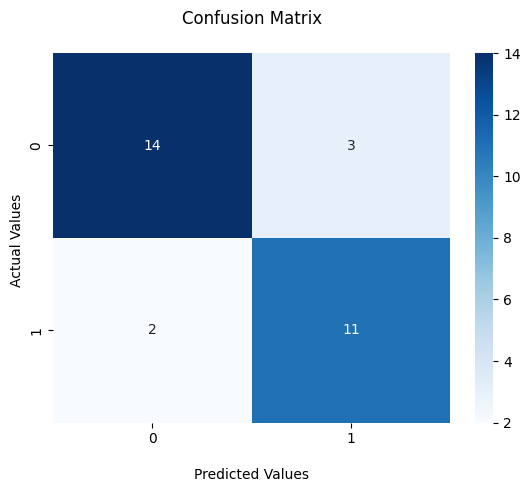

In [17]:
# confusion matrix

cf_matrix = confusion_matrix(y_test, y_pred >= t)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])

##plt.figure(figsize=(7,5))
plt.rcParams['figure.figsize'] = [7, 5]  # re-run this cell to get the correct figure size

plt.show();

<font size="5"> 👏 </font> Como es un contexto médico, queremos evitar los Falsos Negativos y hemos obtenido solo 2, con un porcentaje de aciertos de aproximadamente el 85% (ver los valores de las métricas obtenidos), no está mal. Además, vimos en el Jupyter Notebook anterior que estos hiperparametros nos dan valores de las métricas similares a los de los conjuntos de datos de entrenamiento y validación, por lo que no estamos sobreajustadando ('overfitting') y esperamos que el modelo generalice bien dentro de lo posible.

#### <font color=#ac6240>3.2.2 Evaluación de la calibración del modelo clasificador sobre el conjunto de prueba</font>

Como decíamos más arriba las predicciones de los modelos de aprendizaje automático no están bien calibradas por defecto. Como veremos en la sección <a href=#app-uq>4. Cuantificación de Incertidumbre</a> esto significa que una puntuación igual a 0.2 no quiere decir que haya un 20% de probabilidad de ese sea el valor verdadero de esa predicción. En esa sección explicamos cómo calibrar nuestras predicciones para nuestra clasificación binaria.  

Aquí comprobamos la calibración de nuestro Bosque Aleatorio. Dada "y_pred_positive_class", i.e., la predicción cruda ("raw score") de la clase 1 ("positive class"),  las métricas más apropiadas ("proper scores") son:
+ Brier Score: (y_pred_positive_class - y_true_label)^2
+ Log-Loss (también conocida como logistic loss o cross-entropy loss): 
    + -log(y_pred_positive_class) para la clase 1, y 
    + -log(1-y_pred_positive_class) para la clase 0.
    
Ambas métricas indican mejor calibración cuando su valor se acerca a cero y calibración perfecta cuando valen cero, por eso se denominan ["Strictly Proper Score Rules"](https://www.tandfonline.com/doi/abs/10.1198/016214506000001437).

In [18]:
metrics_list = []
l_loss = log_loss(y_test, y_pred)
brier_loss = brier_score_loss(y_test, y_pred)
metrics_list.append(["Random Forest", acc.round(3), f1.round(3), brier_loss.round(3), l_loss.round(3)])
metrics_list

[['Random Forest', 0.833, 0.815, 0.14, 0.427]]

Vemos que las métricas de rendimiento sobre el conjunto de prueba, exactitud y F1, rondan ambas el 80% y que las métricas de calibración indican que el modelo clasificador no está muy calibrado.

<a href=#toc>Subir a Tabla de Contenidos</a><br>

Empezamos ya a implementar UQ para incluir la certeza de la predicción en lugar de un único valor puntual. Identificaremos así cuando nuestro modelo no está seguro de su predicción y podremos reducir el número de Falsos Negativos.

![Molnar_UQ](./images/Molnar_UQ.png "Molnar_UQ")

[Fuente de la imagen](https://twitter.com/ChristophMolnar)

<a href=#toc>Subir a Tabla de Contenidos</a><br>

<a name='app-uq'/>

## <font color=#ac6240>4. Cuantificacion de incertidumbre</font>

Como mencionamos más arriba, las librerías más populares de Python (Scikit-learn, XGBoost, ... ) púntuan las prediciones con el método `.predict_proba()` que, a pesar de su nombre, en realidad no produce probabilidades (ver por ejemplo, el artículo [_"Are you sure that's a probability?"_](https://kiwidamien.github.io/are-you-sure-thats-a-probability.html)). En Keras `.predict_proba()` quedó obsoleto desde TensorFlow 2.6, hay que usar `.predict()`, en Torch sería por ejemplo, `torch.sigmoid()` para nuestro caso binario. 

Estas puntuaciones crudas o 'raw scores' que salen de la última función de activación (normalmente una sigmoid o softmax, aunque en las capas internars usaras `activation='relu'` ver por ejemplo los [docs de Scikit-learn](https://github.com/scikit-learn/scikit-learn/blob/7b136e9/sklearn/neural_network/multilayer_perceptron.py#L267
)) van entre 0 y 1 y todas juntas suman 1 (por ejemplo, en una tarea de clasificación binaria como la del ejemplo de la sección 1.1 <a href=#project-description-intro>Introducción</a>, si una instancia obtiene 0.9 para la clase "gate", entonces obtiene 0.1 para la clase "perre") pero no por eso son probabilidades porque **no están calibradas, es decir, no es necesariamente cierto que las instancias que obtuvieron 0.9 sean un 90% "gates"**. Como mucho podemos considerarlas solo como 'probabilidades heurísticas' es decir, sin garantía estadística. Asumir que las 'raw scores' son verdaderamente probabilidades causa consecuencias desastrosas a la hora de inferir información o al intentar sumar estas puntuaciones a verdaderas probabilidades, como se explica en [_"How to calibrate your classifier in an intelligent way using Machine Learning Conformal Prediction"_](https://valeman.medium.com/how-to-calibrate-your-classifier-in-an-intelligent-way-a996a2faf718).

Como decíamos, las puntuaciones están calibradas para ser verdaderas probabilidades si, por ejemplo, entre todas las clasificaciones con una puntuación del 90% encontramos la clase verdadera 9 de cada 10 veces. Por ejemplo, cuando en la sección 1.1 <a href=#project-description-intro>Introducción</a> hablábamos de la clasificación binaria de imágenes de "perres" (0) y "gates" (1) y la primera foto (que era une gate) obtenía una 'raw score' de 0.9, para que esa 'raw score' fuera una verdadera probabilidad deberíamos encontrar una foto de une gate el 90% de las veces que una foto obtuviera un 0.9 en la fase de inferencia. Para ver que así sea, hemos de calibrar esa 'raw score' con el numero de imágenes de gates que realmente había en el conjunto de datos de calibración (algo que ni el método `.predict_proba()` ni `.predict()` hacen). Lo que ocurre a menudo es que al calibrar esa 'raw score' obtenemos un nuevo valor. Por ejemplo, la verdadera puntuación (que ya es una verdadera probabilidad) de la foto de ese gate puede que pase de 0.9 a 0.7.

Aquí vamos a explicar la familia de métodos denominados ['Conformal Predictors'](https://en.wikipedia.org/wiki/Conformal_prediction) los cuales funcionan para cualquier modelo de aprendizaje automático y nos permiten calibrar nuestras 'raw scores' para que sean verdaderas probabilidades y en el proceso obtendremos los intervalos de predicción tal que: 

+ de la 'raw score' de 0.9 para el ejemplo de la foto de le gate, obtendríamos algo como [0.75, 0.80], lo que nos da la idea de que el modelo de clasificación está bastante seguro de que es une gate, 
+ de la 'raw score' de 0.5 para el ejemplo de la foto de le perre con espuma en la cabeza, obtendríamos algo como [0.35, 0.65], lo que nos dice que no nos fiemos de ese resultado, y
+ para la imagen de la pájaro la 'raw score' calibrada sería algo como [0.1, 0.8], es decir, algo muy poco fiable que nos avisa que no debemos confiar en esa predicción. 

A continuación aplicamos un ejemplo para nuestra predicción de fallo cardíaco en la sección <a href=#uq-cp>4.1 Conformal Predictors</a>.

<a name='uq-cp'/>

### <font color=#ac6240>4.1 Conformal Predictors</font>

La ['Conformal Prediction'](https://en.wikipedia.org/wiki/Conformal_prediction) es una familia de métodos para cuantizar la incertidumbre de los resultados de un modelo y saber así cuánto podemos confiar en ellos. Recibe su nombre de la denominada medida de no conformidad, o 'nonconformity measure' que cuantiza cuán diferente es la  predicción dentro del conjunto de predicciones que obtuvimos al predecir el conjunto de entrenamiento. Una alta 'nonconformity' indica que el nuevo dato es raro, como la foto de le pájare en el ejemplo de clasificación de perres y gates de la Introducción de este Jupyter Notebook. Algunos autores y autoras la llaman medida de conformidad, es lo mismo, son maneras de hablar.

Las personas que aplicamos Conformal Predictions nos llamamos 'nonconformists'.


<font size="5">😎<font/>
    
Los miembros de la familia de la Prediccón Conforme son esencialmente calibradores de las predicciones que en el proceso de calibración generan regiones de predicción alrededor de dichas predicciones. Cuánto más estrecha es la región, más confiamos en la predicción. Si la predicción puede tomar valores contínuos, como en tareas de regresión, las regiones son intervalos, por ejemplo [49,55] y si pueden tomar valores discretos, como ocurre en clasificación, las regiones son conjuntos ("sets"), por ejemplo ["gate", "perre"].

La Predicción Conforme:

+ es 'model-agnostic', funciona para cualquier modelo de aprendizaje automático y para cualquier tarea, ni siquiera necesita conocer al modelo de aprendizaje automático para el que está cuantizando la incertidumbre de sus predicciones,     
+ ofrece garantía de cobertura demostrada matemáticamente: los intervalos de predicción vienen con garantías de contener el resultado verdadero dado un nivel de confianza determinada, por ejemplo, garantizan contener a la 'ground truth' el 90%, 95%, o 99% de las veces,
+ se aplica en el 'post-processing' sobre las predicciones del modelo de aprendizaje automático ya entrenado (no hay que reentrenar el random forest, en este caso), es decir, una vez obtenidas las predicciones, las conformalizamos,
+ requiere pocas líneas de código y es rápida, 
+ funciona para datos recogidos en tiempo real, es decir, 'online assimilation',
+ a diferencia de los métodos paramétricos, no es necesario asumir que la variable de destino o 'target' está distribuida según una cierta distribución (casi nada en el universo puede aproximarse a una distribución normal y recordemos que el Teorema del Límite Central no indica eso, lo que indica es que las _medias_ de las distribuciones se aproximan a una distribución normal).

De hecho, la única condición para garantizar la cobertura de los intervalos de predicción calculados con 'Conformal Prediction' es que las instancias del conjunto de calibración y prueba sean [intercambiables](https://en.m.wikipedia.org/wiki/Exchangeable_random_variables), es decir, que el orden de los datos no importe, (como en nuestro caso, el clasificador Random Forest no requiere que les pacientes estén ordenades, cualquier ordenación de les pacientes arrojará estadísticamente el mismo resultado) lo cual es una restricción menos fuerte que la típica restricción sobre que los datos han de ser independientes e estar idénticamente distributidos o [iid](https://es.wikipedia.org/wiki/Variables_aleatorias_independientes_e_id%C3%A9nticamente_distribuidas). Aunque desde 2021 ya hay algoritmos de CP para confomalizar series temporales (ver siguiente subsección) que demuestran empíricamente poder generar intervalos de predicción que continene a la predicción verdadera (es decir, la demostración es empírica, no matemática). Y un artículo muy reciente ha demostrado que ni siquiera se necesita asumir intercambiabilidad, aunque el coste computacional de este método es algo: ["_Conformal Validity Guarantees Exist for Any Data Distribution (and How to Find Them)"_](https://arxiv.org/abs/2405.06627). A continuación aplicamos la "Inductive Conformal Prediction" o "Split Conformal Prediction" que no requiere reentrenar el modelo de aprendizaje automático para cada inferencia, en contraposición de la "Transductive Conformal Prediction", la CP original, que implica reentrenar en cada predicción.

Así, la 'Conformal Prediction' nos cuantifica la incertidumbre en forma de intervalos de predicción, también llamados 'conformal intervals' (para tareas de clasificación, 'conformal sets'), que con garantía matemática incluyen la prediccion correcta con cierta probabilidad, lo cual se llama 'coverage guarantee', según el nivel de confianza deseado. Entonces, en lugar de obtener predicciones puntuales ('single-point predictions'), es decir, un número real en el caso de una regresión o la etiqueta de una clase (recordemos el último ejemplo en `Exploration_and_classification.ipynb` donde la nueva paciente obtenia una 'raw score' de 0.32, con el umbral de decisión en 't = 0.4', nos clasificaba a esa paciente con una única clase 'HeartDisease = 0') en el caso de una clasificación, los resultados calibrados con 'Conformal prediction' nos dan un intervalo de números reales o un conjunto de etiquetas, respectivamente.
    
Por ejemplo, aplicando 'Conformal Prediction' a los resultados de un modelo de aprendizaje automático (una Deep Neural Network en PyTorch) para una clasificación de imágenes, vemos que éste:
    
+ no está muy seguro de si la primera foto era un osciloscopio, así que nos lo ofrece como primera opción en un conjunto de predicción con otras dos opciones, 'microondas' y 'portátil', 
+ tampoco está muy seguro de la foto central, de nuevo nos dió la respuesta correcta como primera opción pero el conjunto de predicción contiene también 'refrigerador' y ' lavadora', y
+ está muy seguro de que en la foto de la derecha hay une perre de raza 'Irish Setter' (seguro que ha visto muchos como ese, para el modelo no es para nada una imagen rara), y es la única opción del conjunto de predicción:

![CP_example](./images/CP_4.png "CP_example")

[Fuente de la imagen: Google Colab de A. Angelopoulos desarrollador de MAPIE](https://colab.research.google.com/github/aangelopoulos/conformal_classification/blob/master/example.ipynb#scrollTo=oIiBD-pFVdkD)

Recordamos que los intervalos o conjuntos de predicción que obtenemos con la 'Conformal Prediccion' no son un mero ranking de las 'raw scores' de cada clase si no una región de predicción con garantías estadísticas de que el valor verdadero está dentro de ella.

<font color=#6B8E23 size="4"> Material adicional y referencias</font>

<font color=#6B8E23 size="3"> Cursos, charlas, y blogs

+ Las slides de mi charla ["Conformal Prediction: Key Concepts"](https://docs.google.com/presentation/d/1bQYIFyQysQPx79wJq1mltylsH_aeO2AnLYRlHiLq6vo/edit#slide=id.g2dd387acb29_0_4)
 
+ Los [artículos gratuitos de Medium de Valeriy Manokhin](https://valeman.medium.com/), miembro del grupo de investigación que creó la 'Conformal Prediction' y su [magnífico repositorio](https://github.com/valeman/awesome-conformal-prediction) con materiales sobre CP.
    
+ Este artículo de blog ["Conformal prediction theory explained"](https://medium.com/low-code-for-advanced-data-science/conformal-prediction-theory-explained-14a35226df80) de un miembro del equipo que desarrolla el paquete de Predicción Conforme CREPES explica la Predicción Conforme en general. 

+ El curso gratuito de Christoph Molnar (subscríbete gratis [aquí](https://substack.com/sign-in?redirect=%2Faccount%3Futm_source%3Dsubstack%26utm_medium%3Demail&for_pub=mindfulmodeler&email=&with_password=&change_user=false&justTrying=)), el autor del maravilloso libro gratuito sobre XAI [_"Interpretable Machine Learning"_](https://christophm.github.io/interpretable-ml-book/), que recomendamos en el Jupyter Notebook `XAI.ipynb`, que ahora se ha pasado a la UQ y ha publicado un libro sobre Conformal Prediction <font size="3">♫♫🎈♫♫</font>  (enlace más abajo).
+ El genial post sobre cómo usan Conformal Prediction para conformalizar la clasificación de sus clientes en el [banco BBVA](https://www.bbvaaifactory.com/es/conformal-prediction-an-introduction-to-measuring-uncertainty/)
+ La maravillosa charla _"Quantifying uncertainty in Machine Learning predictions"_ de [Maria Navarro](https://youtu.be/r6bhm_A-YcQ), de las primeras en implementar CP en la industria.
+ La charla sobre Conformal Predictors en el [curso sobre incertidumbre de la Universidad de Pennsylvania](https://uncertaintyclass.com/), este es el [vídeo](https://youtu.be/M3tkM4dcIPA).
+ El blog de los creadores de los 'Conformal Predictors'  [Prof. Vladimir Vovk y Prof. Alex Gammerman:](https://cml.rhul.ac.uk/cp.html).
+ Este [kernel de Kaggle](https://www.kaggle.com/code/carlmcbrideellis/regression-prediction-intervals-with-mapie) que explica como usar los Conformal Predictors en una tarea de regresión.
+ Teoría y ejemplos en el repositorio [A. Angelopoulos](https://github.com/aangelopoulos/conformal-prediction), uno de los dos autores de [_"A Gentle Introduction to Conformal Prediction and Distribution-Free Uncertainty Quantification_"](https://arxiv.org/abs/2107.07511).
    
<font color=#6B8E23 size="3"> Libros

+ El libro de Christoph Molnar [_"Introduction To Conformal Prediction With Python. A Short Guide For Quantifying Uncertainty Of Machine Learning Models"_](https://christophmolnar.com/books/conformal-prediction/).    
+ El nuevo libro de Valeriy Manokhin [_"Practical Guide to Applied Conformal Prediction in Python: Learn and apply the best uncertainty frameworks to your industry applications "_](https://www.packtpub.com/product/practical-guide-to-applied-conformal-prediction-in-python/9781805122760).
+ El libro de los creadores de la Predicción Conforme Vladimir Vovk, Alexander Gammerman, Glenn Shafer ["_Algorithmic Learning in a Random World_"](https://link.springer.com/book/10.1007/b106715)

<font color=#6B8E23 size="3">Paquetes de Python especializados en Conformal Prediction listos para un `pip install`</font>  
+ [MAPIE](https://github.com/scikit-learn-contrib/MAPIE), desarrollada por especialistas en Visión Artificial, incluye algoritmos de CP para clasificación, regresión, y time series,
+ [CREPES](https://github.com/henrikbostrom/crepes), incluye algoritmos de CP para clasificación, regresión, y una implementación de CP llamada "Conformal Predictive Distributions" que produce la cumulative distribution function de cada predición.
+ [R2CCP](https://github.com/EtashGuha/R2CCP), especializada en regresión, calcula la incertidumbre incluso si los datos no están siempre igual de esparcidos (heterocedasticidad) o su distribución es bimodal,
+ [PUNCC](https://github.com/deel-ai/puncc), icluye CP para regresión, clasificación y detección de anomalías,
+ [TorchCP](https://github.com/ml-stat-Sustech/TorchCP) especialmente para Deep Learning, 
+ [Conformal Tights](https://pypi.org/project/conformal-tights/) especializada en problemas de regresión, y
+ [nonconformist](https://github.com/donlnz/nonconformist/blob/master/README.ipynb), el primero que hubo, incluye una implementación de la "Transductive Conformal Prediction".
    


<a name='uq-ivap'/>

### <font color=#ac6240>4.2  Intervalos de predicción de fallo cardíaco con Inductive Venn-ABERS Prediction</font>

Apliquemos la 'Conformal Prediction' a las predicciones de nuestro Bosque Aleatorio. 

Las clasificaciones binarias son especiales porque los conjuntos de predicción generados para las predicciones inciertas no serán muy informativos, simplemente contendrán ambas clases. Por ello para el caso binario es muy útil aplicar la conformalización que crea intervalos de predicción para las probabilidades en lugar de conjuntos de predicción para las clases. Aplicamos entonces la denominada 'Inductive Venn-ABERS Prediction (IVAP)' descrita en el artículo [_"Large-scale probabilistic prediction with and without validity guarantees"_](http://alrw.net/articles/13.pdf) y aplicada en este notebook de Kaggle del grandmaster Carl McBride Ellis [Classifier calibration Using Venn-ABERS](https://www.kaggle.com/code/carlmcbrideellis/classifier-calibration-using-venn-abers). Es un tipo un poco especial de CP porque no requiere la definición de una medida de no conformidad per se, ni de un nivel de confianza para la garantía de cobertura. Consiste en calibrar los resultados con una [Regresión Isotónica](https://docs.google.com/presentation/d/1Q6oxcgmNv0GsmNFA5npAzQGDuy_XolBKStN4KUhP4Gk/edit#slide=id.g2c46ccaba95_0_177) cada posible clase. Es decir, a cada nueve paciente le otorga primero la clase 0 y calcula si es un resultado inusual o no y luego le otorga la clase 1 y calcula si este otro es también un resultado inusual o no. Así obtenemos los límites superior (p1) e inferior (p0) del intervalo de predicción. Para reunir la información en una sola probabilidad, se aplica la fórmula que minimiza la log-loss:  `p_calibrada = p1/(1 - p0 + p1)`.

Este método, al ser "Inductive" requiere de un conjunto de datos de calibración que ya separamos al comienzo del este Jupyter Notebook:

In [19]:
# preparation CALIBRATION data

# reset index after the splitting shuffling
df_cal = df_cal.reset_index(drop=True)
# define target of the test set
y_cal = df_cal.HeartDisease.values
   
# 1. encode the categorical features and remove redundant columns-------------    

cal_dict = df_cal[categorical].to_dict(orient='records')
X_cal_cat = dv.transform(cal_dict) 

# convert the data array to a dataframe
df_X_cal_cat = pd.DataFrame(X_cal_cat,columns= dv.get_feature_names_out())

# remove redundant columns
df_X_cal_cat.drop(['ExerciseAngina=N', 'FastingBS=H', 'Sex=F', 'ST_Slope=Up'], 
                    axis=1, inplace=True)

# convert the dataframe to a np.array again
X_cal_cat = df_X_cal_cat.to_numpy()

# 2. scale the numerical features --------------------------------------------

X_cal_num = df_cal[numerical].values
#X_cal_num = scaler.transform(X_cal_num) 

# 3. join the matrices -------------------------------------------------------

X_cal = np.column_stack([X_cal_num, X_cal_cat]) 

Usamos la implementación del repositorio de [Paolo Toccaceli](https://github.com/ptocca/VennABERS/), que para cada paciente nos calculará los límites superior e inferior de los intervalos de predicción y la probabilidad conformalizada. Simplemente copiamos y pegamos aquí el código:

In [20]:
# Some elementary functions to speak the same language as the paper
# (at some point we'll just replace the occurrence of the calls with the function body itself)
def push(x,stack):
    stack.append(x)
    
def pop(stack):
    return stack.pop()

def top(stack):
    return stack[-1]

def nextToTop(stack):
    return stack[-2]

# perhaps inefficient but clear implementation
def nonleftTurn(a,b,c):   
    d1 = b-a
    d2 = c-b
    return np.cross(d1,d2)<=0

def nonrightTurn(a,b,c):   
    d1 = b-a
    d2 = c-b
    return np.cross(d1,d2)>=0

def slope(a,b):
    ax,ay = a
    bx,by = b
    return (by-ay)/(bx-ax)

def notBelow(t,p1,p2):
    p1x,p1y = p1
    p2x,p2y = p2
    tx,ty = t
    m = (p2y-p1y)/(p2x-p1x)
    b = (p2x*p1y - p1x*p2y)/(p2x-p1x)
    return (ty >= tx*m+b)

kPrime = None

# Because we cannot have negative indices in Python (they have another meaning), I use a dictionary

def algorithm1(P):
    global kPrime
    
    S = []
    P[-1] = np.array((-1,-1))
    push(P[-1],S)
    push(P[0],S)
    for i in range(1,kPrime+1):
        while len(S)>1 and nonleftTurn(nextToTop(S),top(S),P[i]):
            pop(S)
        push(P[i],S)
    return S

def algorithm2(P,S):
    global kPrime
    
    Sprime = S[::-1]     # reverse the stack

    F1 = np.zeros((kPrime+1,))
    for i in range(1,kPrime+1):
        F1[i] = slope(top(Sprime),nextToTop(Sprime))
        P[i-1] = P[i-2]+P[i]-P[i-1]
        if notBelow(P[i-1],top(Sprime),nextToTop(Sprime)):
            continue
        pop(Sprime)
        while len(Sprime)>1 and nonleftTurn(P[i-1],top(Sprime),nextToTop(Sprime)):
            pop(Sprime)
        push(P[i-1],Sprime)
    return F1

def algorithm3(P):
    global kPrime

    S = []
    push(P[kPrime+1],S)
    push(P[kPrime],S)
    for i in range(kPrime-1,0-1,-1):  # k'-1,k'-2,...,0
        while len(S)>1 and nonrightTurn(nextToTop(S),top(S),P[i]):
            pop(S)
        push(P[i],S)
    return S

def algorithm4(P,S):
    global kPrime
    
    Sprime = S[::-1]     # reverse the stack
    
    F0 = np.zeros((kPrime+1,))
    for i in range(kPrime,1-1,-1):   # k',k'-1,...,1
        F0[i] = slope(top(Sprime),nextToTop(Sprime))
        P[i] = P[i-1]+P[i+1]-P[i]
        if notBelow(P[i],top(Sprime),nextToTop(Sprime)):
            continue
        pop(Sprime)
        while len(Sprime)>1 and nonrightTurn(P[i],top(Sprime),nextToTop(Sprime)):
            pop(Sprime)
        push(P[i],Sprime)
    return F0

def prepareData(calibrPoints):
    global kPrime
    
    ptsSorted = sorted(calibrPoints)
    
    xs = np.fromiter((p[0] for p in ptsSorted),float)
    ys = np.fromiter((p[1] for p in ptsSorted),float)
    ptsUnique,ptsIndex,ptsInverse,ptsCounts = np.unique(xs, 
                                                        return_index=True,
                                                        return_counts=True,
                                                        return_inverse=True)
    a = np.zeros(ptsUnique.shape)
    np.add.at(a,ptsInverse,ys)
    # now a contains the sums of ys for each unique value of the objects
    
    w = ptsCounts
    yPrime = a/w
    yCsd = np.cumsum(w*yPrime)   # Might as well do just np.cumsum(a)
    xPrime = np.cumsum(w)
    kPrime = len(xPrime)
    
    return yPrime,yCsd,xPrime,ptsUnique

def computeF(xPrime,yCsd):
    global kPrime
    P = {0:np.array((0,0))}
    P.update({i+1:np.array((k,v)) for i,(k,v) in enumerate(zip(xPrime,yCsd))})
    
    S = algorithm1(P)
    F1 = algorithm2(P,S)
    
    P = {0:np.array((0,0))}
    P.update({i+1:np.array((k,v)) for i,(k,v) in enumerate(zip(xPrime,yCsd))})    
    P[kPrime+1] = P[kPrime] + np.array((1.0,0.0))    # The paper says (1,1)
    
    S = algorithm3(P)
    F0 = algorithm4(P,S)
    
    return F0,F1

def getFVal(F0,F1,ptsUnique,testObjects):
    pos0 = np.searchsorted(ptsUnique,testObjects,side='left')
    pos1 = np.searchsorted(ptsUnique[:-1],testObjects,side='right')+1
    return F0[pos0],F1[pos1]

def ScoresToMultiProbs(calibrPoints,testObjects):
    # sort the points, transform into unique objects, with weights and updated values
    yPrime,yCsd,xPrime,ptsUnique = prepareData(calibrPoints)
    
    # compute the F0 and F1 functions from the CSD
    F0,F1 = computeF(xPrime,yCsd)
    
    # compute the values for the given test objects
    p0,p1 = getFVal(F0,F1,ptsUnique,testObjects)
                    
    return p0,p1

Aplicando la función `ScoresToMultiProbs()` a  la lista de pares '(raw_score, true value)' de las predicciones del Bosque Aleatorio que obtuvimos sobre el conjunto de entrenamiento, y la 'raw score' de la instancia dada (une nueve paciente, por ejemplo del conjunto de prueba),  obtenemos el límite inferior 'p0' y superior 'p1' de nuestro intervalos de predicción para la probabilidad bien calibrada para la clase '1', en nuestro caso la probabilidad de pertenecer al grupo en riesgo de sufrir fallo cardíaco. Como decíamos más arriba, la probabilidad calibrada de 'HeartDisease=1' para ese paciente se calcula con la fórmula `p_calibrada = p1/(1 - p0 + p1)` que se obtiene a partir de los límites de nuestro intervalo.

Apliquemos la conformalización a todo el conjunto de prueba:

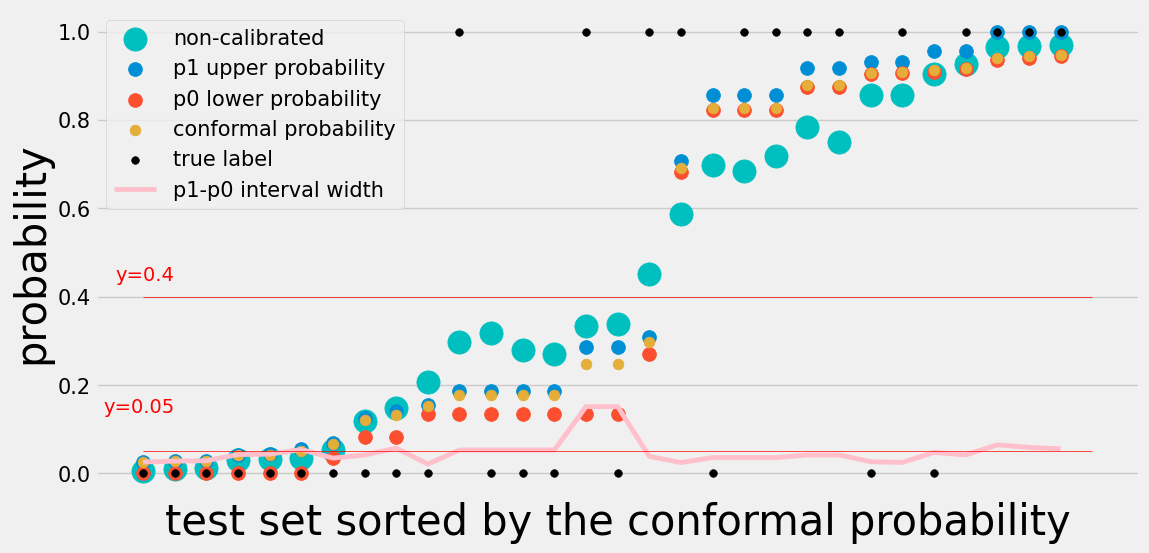

In [23]:
# calibrPts: a list of pairs (score,label) corresponding to the scores and labels of the calibration examples.
y_pred_cal = RF.predict_proba(X_cal)[:,1] 
calibrPts = zip(list(y_pred_cal),list(y_cal))

# testScores: a list of floats corresponding to the scores for the test objects.
testScores = RF.predict_proba(X_test)[:,1]  

# interval bounds
p0,p1 = ScoresToMultiProbs(calibrPts,testScores)

# united probability that minimizes the log loss https://towardsdatascience.com/intuition-behind-log-loss-score-4e0c9979680a 
p = p1/(1-p0+p1) 

predictions = pd.Series(y_test).to_frame()
predictions.columns = ['y_true']
predictions["raw scores"] = (testScores)# >= 0.4)
predictions["p0"] = p0 # lower bound
predictions["p1"] = p1 # upper bound
predictions["p"]  = p # estimated probability
predictions["width"] = predictions["p1"] - predictions["p0"] # interval for UQ
predictions = predictions.sort_values(by=['p'])
predictions = predictions.reset_index()

plt.style.use('fivethirtyeight')

fig, ax = plt.subplots(figsize=(12, 6))
s =30
plt.scatter(x=predictions.index,y=predictions["raw scores"],label="non-calibrated", marker = 'o', s = s + 250 , color = 'c')
plt.scatter(x=predictions.index,y=predictions["p1"],label="p1 upper probability",s=s +70)
plt.scatter(x=predictions.index,y=predictions["p0"],label="p0 lower probability",s=s +70)
plt.scatter(x=predictions.index,y=predictions["p"],label="conformal probability",s=s +30, marker = 'o')
plt.scatter(x=predictions.index,y=predictions["y_true"],label="true label",s= s, marker = 'o', color = "k")

plt.plot(predictions.index,predictions["width"],label="p1-p0 interval width",lw=3.5,color="pink")

# decision thershold
plt.hlines(y=0.4, xmin=0, xmax=30, lw=0.5, color='red')
plt.text(1, 0.45, 'y=0.4', ha='right', va='center', color='red')
# 90% confidence in intervals
plt.hlines(y=0.05, xmin=0, xmax=30, lw=0.5, color='red')
plt.text(1, 0.15, 'y=0.05', ha='right', va='center', color='red')

#plt.legend(loc="upper left",fontsize=16, scatterpoints=1, markerscale=1)
plt.legend(fontsize=15, scatterpoints=1, markerscale=1)

plt.ylabel("probability",fontsize=30)
plt.xlabel("test set sorted by the conformal probability", fontsize=30)
plt.xticks([])
plt.rc('ytick', labelsize= 15)
plt.rc('xtick', labelsize= 15)
#plt.savefig('All_test_probabilities.pdf')
plt.show()

Podemos decidir no automatizar aquellas cuyo intervalo sea muy grande, más grande que el nivel de confianza $\epsilon$, por ejemplo 0.05, para una confianza del 95%.

Vemos que la Prediccion Conforme en este caso no consigue reclasificar correctamente los 2 Falsos Negativos pero nos ofrece intervalos de predicción mayores que el riesgo acceptado. Con la anchura mayor de 0.05, la conformalización nos indica que no debemos confiar en estas predicciones.

Por desgracia ambos Falsos Positivos tienen un intervalo de predicción es muy estrechito, la confomalización indica erróneamente que es un resultado confiable. La Predicción Conforme sobre el Bosque Aleatorio no ha sido lo suficientemente potente para identificar lo inusual de estos resultado y los clasifica como confiables a pesar de ser erróneos. Solo un nivel de confianza del 99% (i.e., $\epsilon$ = 0.01) habría detectado estos casos. La clasificación de estes pacientes es particularmenete complicada. Cómo siempre, aumentar el tamaño de los conjuntos de entrenamiento y calibración también puede que mejorara los resultados, no tanto por la parte de la conformalización sino porque aumentaría el rendimiento del Bosque Aleatorio.

#### Evaluación de la conformalización con IVAP

In [22]:
# performance metrics with decision threshold t = 0.4
acc = accuracy_score(y_test, p >= 0.4)
f1 = f1_score(y_test, p >= 0.4)

# calibration metrics after conformalizing with IVAP
l_loss = log_loss(y_test, p)
brier_loss = brier_score_loss(y_test, p)

metrics_list.append(["Random Forest + IVAP", acc.round(3), f1.round(3), brier_loss.round(3), l_loss.round(3)])


metrics_df = pd.DataFrame(metrics_list, columns = [
    'Classifier', 'W-accuracy','F1-score', 'Brier Score', 'Log Loss'])
metrics_df.set_index('Classifier', inplace=True)
metrics_df.columns = pd.MultiIndex.from_tuples([ 
                              ('   Performance metrics:', 'Weighted Acc'),('   Performance metrics:', 'F1-score'), 
                              ('Calibration metrics:', 'Brier Score'),('Calibration metrics:', 'Log Loss')])

metrics_df.round(2)

Performance metrics:          Calibration metrics:  \
                                Weighted Acc F1-score          Brier Score   
Classifier                                                                   
Random Forest                           0.83     0.82                 0.14   
Random Forest + IVAP                    0.80     0.77                 0.15   

                               
                     Log Loss  
Classifier                     
Random Forest            0.43  
Random Forest + IVAP     0.46

La conformalización con IVAP nos da intervalos de predicción pero esta vez no ha mejorado la calibración ni el rendimiento, lo cual no es lo que queríamos mostrar y que habría que investigar por qué hemos obtenido este resultado tan inusual, que, cómo decíamos, puede deberse al pequeño volumen o las carácteristica del conjunto de datos que hacen que el modelo clasificador sea menos efectivo. Porque hemos de tener en cuenta que la calidad de la UQ depende de la calidad del model clasificador cuya incertidumbre cuantifica.

Para ver ejemplos donde la IVAP muestra todo su pontencial descubriendo y arreglando Falsos Negativos en medicina y calibrando mejor que otros métodos de calibración populares ([Platt Scaling](https://scikit-learn.org/stable/modules/calibration.html#sigmoid) e [Isotonic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.isotonic.IsotonicRegression.html), que no ofrecen garantía de cobertura) ver por ejemplo:

+ este [artículo de conferencia]([https://ceur-ws.org/Vol-3831/paper17.pdf), y  
+ este [Jupyter Notebook de Xema Belmonte Marín](https://github.com/xemauoc/TFG/blob/main/TFG_04_Incertidumbre.ipynb). 

Las predicciones con más incerticumbre tienen los intervalos de predicción son más grandes. Podemos decidir no automatizar aquellas cuyo intervalo sea muy grande, más grandes que el nivel de confianza' $\epsilon$, por ejemplo 0.05, para una confianza del 95%. En un ejemplo real implementaremos una señal de fallback y el programa nos dirá 'no puedo predecir, no tengo ni idea' y puede ser preferible una inversión en tiempo humano para la clasificación manual de esa instancia que asumir las clasificaciones incorrectas. Por ejemplo, en nuestro caso, une experte en medicina evaluaría a eses pacientes seleccionados gracias a la cuantifición de incertidumbre y les dirigiría a hacerse nuevas pruebas médicas, por ejemplo.

<a name='uq-others'/>

### <font color=#ac6240>4.3 Otros métodos de UQ para aprendizaje supervisado</font>

Hay miembros de la familia de la Predicción Conforme para todo tipo de tareas y modelos de aprendizaje automático. Sin embargo, al contrario que la mayoría de los métodos de explicabilidad que mostramos en el Jupyter Notebook anterior `XAI.ipynb`, muchos métodos de UQ en general y de CP en particular son específicos, por ejemplo, se aplican solo a tareas de regresión. Mencionaremos algunos muy populares y cabe mencionar que:

+ todos los métodos de UQ que no usen CP se deben calibrar con 'Conformal Predictions' o estarímos en las mismas que cuando solo nos preocupa el renedimiento y usamos solo los 'raw scores' de `.predict_proba()`.

+ solo la Conformal Prediction nos da garantía de cobertura de que el resultado contiene el valor verdadero. Por ejemplo, la primera columna de siguiente tabla del artículo [Valid prediction intervals for regression problems](https://link.springer.com/article/10.1007/s10462-022-10178-5) (en Arxiv está la [última versión](https://arxiv.org/abs/2107.00363)) dónde se revisan varios métodos de UQ para regresión.

![Waegeman_benchmark](./images/Waegeman_UQ_benchmark.png "Waegeman_benchmark")

[Fuente de la imagen: Valid prediction intervals for regression problems](https://link.springer.com/article/10.1007/s10462-022-10178-5), en Arxiv está la [última versión](https://arxiv.org/abs/2107.00363). 

<font color=#ac6240>Paquetes que implementan CP y otros métodos de UQ para cualquier tarea </font>
+ [PiML](https://selfexplainml.github.io/PiML-Toolbox/_build/html/guides/testing/reliability.html)
+ [AWS Fortuna](https://github.com/awslabs/fortuna?tab=readme-ov-file) (para CP con time series soluciona el asunto de la intercambiabilidad implementando [EnbPI](https://proceedings.mlr.press/v139/xu21h/xu21h.pdf), como hace MAPIE)
+ [Lightning UQ Box](https://github.com/lightning-uq-box/lightning-uq-box) 

<font color=#ac6240>Tareas de Regresión</font>

El artículo y el Jupyter Notebook del [tutorial de Martim Sousa](https://github.com/Quilograma/ConformalPredictionTutorial/tree/main) (también incluye la explicación para la Quantile Regression, ver siguiente punto aquí abajo).


<font color=#ac6240>Quantile Regression</font>

Pertenece al grupo "Direct Interval Estimation" de la tabla anterior.

+ Una breve y genial explicación de la [Quantile Regression escrita por Christoph Molnar](https://mindfulmodeler.substack.com/p/how-i-made-peace-with-quantile-regression) y sobre como [conformalizarla aquí](https://mindfulmodeler.substack.com/p/week-3-conformal-prediction-for-regression).
+ Más sobre conformalizar la Quantile Regression en [_"A Gentle Introduction to Conformal Prediction and Distribution-Free Uncertainty Quantification"_](https://arxiv.org/pdf/2107.07511.pdf) sección "2. Examples of Conformal Procedures" y [_"Another (Conformal) Way to Predict Probability Distributions: Conformal multi-quantile regression with Catboost"_](https://towardsdatascience.com/another-conformal-way-to-predict-probability-distributions-fcc63e78680d).

<font color=#ac6240>Ensembles</font>

Suelen ser computacionalmente costosos porque implican entrenar muchas versiones de los modelos de aprendizaje automático y no ofrecen garantía de cobertura. Un ejemplo de aplicación:  [_"Simple and Scalable Predictive Uncertainty Estimation using Deep Ensembles"_](https://papers.nips.cc/paper/2017/hash/9ef2ed4b7fd2c810847ffa5fa85bce38-Abstract.html).

<font color=#ac6240>Bayesianos</font>

Suelen ser computacionalmente costosos porque implican predecir la distribución completa, siempre dependen de un prior que puede ser difícil de estimar y por lo tanto no ser fiable, y no garantizan la cobertura. Para que los resultados de los métodos bayesianos cumplan "validity" pueden conformalizarse, ver por ejemplo:

+ [Valid prediction intervals for regression problems](https://link.springer.com/article/10.1007/s10462-022-10178-5) (en Arxiv está la [última versión](https://arxiv.org/abs/2107.00363)), 
+ [Bayesian Optimization with Formal Safety Guarantees via Online Conformal Prediction](https://arxiv.org/abs/2306.17815), and 
+ [Online Calibrated and Conformal Prediction Improves Bayesian Optimization](https://proceedings.mlr.press/v238/deshpande24a/deshpande24a.pdf).

Sobre métodos bayesianos en general:

+ Este artículo en este blog: [El Paradigma Bayes para escenarios de incertidumbre](https://keepler.io/es/2020/03/el-paradigma-bayes-para-escenarios-de-incertidumbre/).

+ La librería de Python [PyMC3](https://pypi.org/project/pymc3/) (que ahora se llama [PyMC](https://www.pymc.io/blog/v4_announcement.html)) y el repo [Probabilistic Python: An Introduction to Bayesian Modeling with PyMC](https://github.com/fonnesbeck/probabilistic_python).

+ Métodos Bayesianos para clasificación y regresión como BART [Bayesian Additive Regression Trees](https://jmloyola.github.io/posts/2019/06/introduction-to-bart)

+ Para 'Gaussian Processes', ver por ejemplo: [_"Easy introduction to gaussian process regression (uncertainty models)"_](https://youtu.be/iDzaoEwd0N0) y [_"Coding gaussian process regressors FROM SCRATCH in python"_](https://youtu.be/JXdrq7--XV0) con este [repo](https://gitlab.com/youtube-optimization-geeks/uncertainty-quantification/-/blob/main/coing_gpr_from_scratch_notebook.ipynb).

+ Para Deep Learning, la charla _"Are you sure about that?! Uncertainty Quantification in AI"_ de [Florian Wilhelm](https://youtu.be/LCDIqL-8bHs) con aplicaciones en Deep Learning para tareas de regresión.

<font color=#ac6240>Para la predicción de Time Series, donde los datos no son intercambiables</font>

+ La explicación de cómo usar la libreria `MAPIE` con los Conformal Predictors para UQ en time series: [_"Time Series Forecasting with Conformal Prediction Intervals: Scikit-Learn is All you Need"_](https://towardsdatascience.com/time-series-forecasting-with-conformal-prediction-intervals-scikit-learn-is-all-you-need-4b68143a027a). Soluciona el asunto de la intercambiabilidad implementando [EnbPI](https://proceedings.mlr.press/v139/xu21h/xu21h.pdf), como hace AWS Fortuna.

+ [NeuralProphet](https://pypi.org/project/neuralprophet/) tiene implementada la función `.conformal_predict()` para conformalizar la Quantile Regression en time series, [este Jupyter Notebook](https://github.com/ourownstory/neural_prophet/blob/main/tutorials/feature-use/uncertainty_conformal_prediction.ipynb) contiene un ejemplo prediciendo la demanda de energia de un hospital. 

+ [MLforecast](https://nixtlaverse.nixtla.io/mlforecast/docs/how-to-guides/prediction_intervals.html) y el modelo fundacional [TimeGPT](https://nixtlaverse.nixtla.io/nixtla/docs/tutorials/prediction_intervals.html) de Nixtla incluyen CP. Solucionan el asunto de la incercambiabilidad implementando [CFTS](https://proceedings.neurips.cc/paper_files/paper/2021/file/312f1ba2a72318edaaa995a67835fad5-Paper.pdf).

+ [Sktime](https://www.sktime.net/en/stable/examples/01b_forecasting_proba.html) También solucionan el asunto de la incercambiabilidad implementando [CFTS](https://proceedings.neurips.cc/paper_files/paper/2021/file/312f1ba2a72318edaaa995a67835fad5-Paper.pdf).

En esta presentación [_"Conformal Prediction for Time Series Forecasting"_](https://docs.google.com/presentation/d/1oVezKS5pimcQq21-slBHRq-lJBUNftyZENX3JGoNzXo/edit#slide=id.g2e4d971ff01_0_14) incluímos una lista con todas las fuentes actualizadas y una breve explicación de algunos algotirmos de CP para time series forecasting.

<a name='miscelanea'/>

### <font color=#ac6240>4.3 Miscelánea</font>

<font color=#ac6240>GAMLSS</font>

Los Generalized Additive Models for Location, Scale and Shape son modelos de regresión que no predicen los valores de la variable de destino o 'target' sino que predicen los parametros que definen su distribución, es decir, la localización (por ejemplo, la media), la escala (por ejemplo, la varianza), y la forma (por ejemplo, la kurtosis y la 'skewness'), más info en [este artículo](https://www.cienciadedatos.net/documentos/63_gamlss.html).    

La librería [Lightning UQ Box](https://github.com/lightning-uq-box/lightning-uq-box) implementa la "Mean-Variance Estimation" donde el resultado de la red neuronal es la media y la varianza de la distribución de la predicción pero asumiendo entonces que los resultados están distribuidos según una distribución normal (recordamos que los Conformal Predictors no son paramétricos, son distribution-free).

<font color=#ac6240>Trustworthy AI: UQ + XAI</font>

Podemos aplicar UQ no solo a los resultados de la predicción sino a los resultados de la XAI que obtuvimos en el anterior Jupyter Notebook sobre explicabilidad en este taller y dotar de intervalos de predicción a los Shapley Values, como en este artículo: [But Are You Sure? An Uncertainty-Aware Perspective on Explainable AI](https://proceedings.mlr.press/v206/marx23a/marx23a.pdf) o como en este artículo sobre  [conformalizar los valores de Shapley](https://raw.githubusercontent.com/mlresearch/v230/main/assets/alkhatib24a/alkhatib24a.pdf).

<font color=#ac6240>Causal Inference</font>

+ Blogs como [Causal Inference for The Brave and True](https://matheusfacure.github.io/python-causality-handbook/landing-page.html) 
+ La charla _"Introducción a la causalidad en Python "_ de [Albert Pujol Torras y Miguel F. Alarcón](https://charlas.2022.es.pycon.org/pycones2022/talk/FTGTLS/) en la PyConES 2022.

Los métodos de causalidad también han de conformalizarse, por ejemplo:

+ [Conformal Counterfactual Inference under Hidden Confounding](https://arxiv.org/abs/2405.12387)

+ [Conformal convolution and Monte Carlo meta-learners for predictive inference of individual treatment effects](https://arxiv.org/pdf/2402.04906)

+ [Conformal Prediction for Causal Effects of Continuous Treatments](https://arxiv.org/abs/2407.03094)

+ [On the Role of Surrogates in Conformal Inference of Individual Causal Effects](https://arxiv.org/abs/2412.12365)

<font color=#ac6240>Modelos híbridos</font>

Son aquellos que incluyen 'domain expertise' para comprobar que se cumplen las restricciones que tenga el sistema, (por ejemplo las leyes de conservación de la energía y la masa, limitaciones de presupuesto,...) o para 'feature engineering'; un ejemplo son las Physic Guided o [Physic Informed Neural Networks](https://en.wikipedia.org/wiki/Physics-informed_neural_networks) como en el artículo [_"Physics-guided Neural Networks (PGNN): An Application in Lake Temperature Modeling"_](https://arxiv.org/pdf/1710.11431.pdf) un ejemplo de una red neuronal artificial aplicada en hidrología que arrojaba soluciones que permitían que agua líquida más densa flotara sobre agua líquida menos densa. 

**Si es que si no se lo dices, todo esto al algoritmo le da igual**.


<font size="6">🤦🏻‍♀️</font>

La librería [SciANN](https://www.sciann.com/#new-to-sciann) permite modificar la loss function de las redes neuronales para penalizar aquellas soluciones que violen las limitaciones o restricciones del sistema.

Un ejemplo de la conformalización de una PINN: [_"Conformalized Physics-Informed Neural Networks"_](https://arxiv.org/abs/2405.08111).

<a href=#toc>Subir a Tabla de Contenidos</a><br>

<a name='uq-end'/>

### <font color=#ac6240>5. Conclusión sobre la cuantificación de incertidumbre</font>

Aplicando Conformal Prediction a nuestros resultados hemos conseguido identificar la aquellos pacientes sobre cuya clasificacion el bosque aleatorio no estaba muy seguro. Podemos entonces automatizar solo las predicciones seguras y reducir así nuestra cantidad de Falsos Negativos y Positivos. 

Vemos que son métodos fáciles de implementar y rápidos, y nos proporcionan probabilidades rigurosas.


<font size="5">🎈♫♫🎈🎈♫🎈♫♫♫♫🎈🎈 ♫♫♫ 🎈🎈</font>

<a href=#toc>Subir a Tabla de Contenidos</a><br>

Ya no queda tiempo para más, nos vemos en el próximo taller. 

<font size="5">☀️⛱️ </font> Buen trabajo y hasta pronto!

